---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
# CORD-19: Question-Answer (QA) model and Topic modelling
---------------------------------------------------------
@authors  
     Djiby BALDE [GitHub](https://github.com/djibybalde)  
     Tatiana MAIA [GitHub](https://github.com/tatianamaia)  
     Students at Aix-Marseille School of Economics, Marseille, France
     
### AIM:
The aim of the exercise is to study the literature provided by the Kaggle in the COVID-19 Open Research Dataset (CORD-19) in order to answer a total of 8 taks. 

Our aim is to try to built a QA model that can answer all the CORD-19 tasks. 

This notebook is decomposed in 3 parts: 

   * 1st: Data Processing
    
   * 2nd: QA model: This model is based in the following notebook:  https://www.kaggle.com/jonathanbesomi/a-qa-model-to-answer-them-all
    
   * 3rd: Topic modelling  

This notebook was inspired on multiple works on Kaggle and Github.  
`References are listed below`

---------------------
# **Data Processing**
## Necessary Libraries

In [1]:
import sys, os, re, glob, json 
import torch, string

import numpy as np, pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 

from datetime import datetime
from matplotlib.pyplot import figure
from matplotlib.patches import Rectangle
from pathlib import Path, PurePath
from pprint import pprint

# Language detection 
import scispacy, spacy, en_core_sci_sm
from spacy_langdetect import LanguageDetector

# Gensim 
import gensim, spacy, logging, warnings 
import gensim.corpora as corpora 
from gensim.utils import lemmatize, simple_preprocess 
from gensim.models import CoherenceModel 

# NLTK 
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import sent_tokenize, word_tokenize 

# Search engine
from rank_bm25 import BM25Okapi 


In [2]:
if not sys.warnoptions: 
    import warnings 
    warnings.simplefilter("ignore")

plt.style.use('ggplot')

# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

# The path
path = '../CORD-19-research-challenge/'

In [3]:
"""
# trying to use the GPU from tensorflow
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.compat.v1.Session(config=config)"""

'\n# trying to use the GPU from tensorflow\nimport tensorflow as tf\n\nconfig = tf.compat.v1.ConfigProto()\nconfig.gpu_options.allow_growth = True\n\nsess = tf.compat.v1.Session(config=config)'

## Metadata 

In [4]:
metadata_df = pd.read_csv(f'{path}metadata.csv',
                          parse_dates=['publish_time'],
                          dtype={'pubmed_id':str, 'Microsoft Academic Paper ID':str},
                          low_memory=False)

metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47298 entries, 0 to 47297
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   cord_uid                     47298 non-null  object        
 1   sha                          34283 non-null  object        
 2   source_x                     47298 non-null  object        
 3   title                        47140 non-null  object        
 4   doi                          43956 non-null  object        
 5   pmcid                        28038 non-null  object        
 6   pubmed_id                    35409 non-null  object        
 7   license                      47298 non-null  object        
 8   abstract                     39048 non-null  object        
 9   publish_time                 47289 non-null  datetime64[ns]
 10  authors                      45189 non-null  object        
 11  journal                      42894 non-nu

In [5]:
metadata_df = metadata_df[['sha', 'title', 'authors', 'journal', 'publish_time', 'abstract']]
metadata_df = metadata_df[metadata_df.sha.isna()==False]
metadata_df.rename(columns={'sha':'paper_id'}, inplace=True)


In [6]:
# If the number of authors is greater than two, we keep the first one and replace the other by "et al." 
authors = []
for author in metadata_df.authors.astype(str):
    if len(author.split('; ')) > 2:
        authors.append(author.split('; ')[0]+' et al.')
    else:
        authors.append(author)

metadata_df['authors'] = authors
metadata_df['abstract'] = [str(a).replace('Abstract ','') for a in metadata_df.abstract]

metadata_df.head()

,paper_id,title,authors,journal,publish_time,abstract
3,aecbc613ebdab36753235197ffb4f35734b5ca63,Clinical and immunologic studies in identical twins discordant for systemic lupus erythematosus,"Brunner, Carolyn M. et al.",The American Journal of Medicine,1973-08-31,"Middle-aged female identical twins, one of whom had systemic lupus erythematosus (SLE), were eva..."
5,212e990b378e8d267042753d5f9d4a64ea5e9869,Infectious diarrhea: Pathogenesis and risk factors,"Cantey, J.Robert",The American Journal of Medicine,1985-06-28,"Our understanding of the pathogenesis of infectious, especially bacterial, diarrhea has increase..."
6,bf5d344243153d58be692ceb26f52c08e2bd2d2f,New perspectives on the pathogenesis of rheumatoid arthritis,"Zvaifler, Nathan J.",The American Journal of Medicine,1988-10-14,"In the pathogenesis of rheumatoid arthritis, locally produced antibodies complex with an incitin..."
7,ddd2ecf42ec86ad66072962081e1ce4594431f9c,Management of acute and chronic respiratory tract infections,"Ellner, Jerrold J.",The American Journal of Medicine,1988-09-16,"Pharyngitis, bronchitis, and pneumonia represent the most common respiratory tract infections. W..."
8,a55cb4e724091ced46b5e55b982a14525eea1c7e,Acute bronchitis: Results of U.S. and European trials of antibiotic therapy,"Dere, Willard H.",The American Journal of Medicine,1992-06-22,"Acute bronchitis, an illness frequently encountered by primary-care physicians, is an inflammati..."


## Extract the body text of the papers from JSON files

In [7]:
# Path for reading all the JSON files
pdf_json = glob.glob(path+'**/pdf_json/*.json', recursive=True)
pmc_json = glob.glob(path+'**/pmc_json/*.json', recursive=True)

print(f'pdf_json contains {len(pdf_json)} JSON files')
print(f'pmc_json contains {len(pmc_json)} JSON files')

pdf_json contains 36236 JSON files
pmc_json contains 15861 JSON files


In [8]:
with open(pdf_json[0], mode='r') as file:
     contents = json.loads(file.read())
        
contents.keys()

dict_keys(['paper_id', 'metadata', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'back_matter'])

In [9]:
%%time
papers_df = pd.DataFrame(columns=['paper_id','body_text'])

for j in range(len(pdf_json)):
    if j%(len(pdf_json)//10)==0:
        print(f'Processing index: {j} of {len(pdf_json)} ==> {round(100*j/len(pdf_json))}%')  
    
    # Read the JSON files
    with open(pdf_json[j], mode='r') as file:
        contents = json.loads(file.read())
        
    # Append the ID paper
    papers_df.loc[j,'paper_id'] = contents['paper_id']
    
    # Append the 'body_text'
    texts = []
    for text in contents['body_text']:
        texts.append(text['text'])
    body_text = '\n '.join(texts)
    papers_df.loc[j,'body_text'] = body_text

Processing index: 0 of 36236 ==> 0%
Processing index: 3623 of 36236 ==> 10%
Processing index: 7246 of 36236 ==> 20%
Processing index: 10869 of 36236 ==> 30%
Processing index: 14492 of 36236 ==> 40%
Processing index: 18115 of 36236 ==> 50%
Processing index: 21738 of 36236 ==> 60%
Processing index: 25361 of 36236 ==> 70%
Processing index: 28984 of 36236 ==> 80%
Processing index: 32607 of 36236 ==> 90%
Processing index: 36230 of 36236 ==> 100%
CPU times: user 3min 11s, sys: 16.8 s, total: 3min 28s
Wall time: 3min 52s


## Merging the metadata and the body text of the papers

In [10]:
%%time
cord19_df = pd.merge(metadata_df, papers_df, on=['paper_id'], how='inner')
cord19_df.drop_duplicates(['paper_id', 'body_text'], inplace=True)

cord19_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32417 entries, 0 to 32424
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   paper_id      32417 non-null  object        
 1   title         32381 non-null  object        
 2   authors       32417 non-null  object        
 3   journal       31003 non-null  object        
 4   publish_time  32417 non-null  datetime64[ns]
 5   abstract      32417 non-null  object        
 6   body_text     32417 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 2.0+ MB
CPU times: user 4.62 s, sys: 5.86 s, total: 10.5 s
Wall time: 16.2 s


In [11]:
cord19_df['body_text'].describe(include='all')

count                                                                                                   32417
unique                                                                                                  32401
top       In previous reports, workers have characterized the presentation of Middle East Respiratory Synd...
freq                                                                                                        4
Name: body_text, dtype: object

In [12]:
cord19_df.head()

,paper_id,title,authors,journal,publish_time,abstract,body_text
0,aecbc613ebdab36753235197ffb4f35734b5ca63,Clinical and immunologic studies in identical twins discordant for systemic lupus erythematosus,"Brunner, Carolyn M. et al.",The American Journal of Medicine,1973-08-31,"Middle-aged female identical twins, one of whom had systemic lupus erythematosus (SLE), were eva...","The patient (Fo, ) was a 58 year old mentally retarded white woman, born in a rural area of sout..."
1,212e990b378e8d267042753d5f9d4a64ea5e9869,Infectious diarrhea: Pathogenesis and risk factors,"Cantey, J.Robert",The American Journal of Medicine,1985-06-28,"Our understanding of the pathogenesis of infectious, especially bacterial, diarrhea has increase...","Pathogenesis and Risk Factors J. ROBERT CANTEY, M.D. Charleston, South Carolina Our understandin..."
2,bf5d344243153d58be692ceb26f52c08e2bd2d2f,New perspectives on the pathogenesis of rheumatoid arthritis,"Zvaifler, Nathan J.",The American Journal of Medicine,1988-10-14,"In the pathogenesis of rheumatoid arthritis, locally produced antibodies complex with an incitin...","In the pathogenesis of rheumatoid arthritis, locally produced antibodies complex with an incitin..."
3,ddd2ecf42ec86ad66072962081e1ce4594431f9c,Management of acute and chronic respiratory tract infections,"Ellner, Jerrold J.",The American Journal of Medicine,1988-09-16,"Pharyngitis, bronchitis, and pneumonia represent the most common respiratory tract infections. W...","Respiratory Tract Infections JERROLD J. ELLNER, M.D. Cleveland, CM Pharyngitis, bronchitis, and ..."
4,a55cb4e724091ced46b5e55b982a14525eea1c7e,Acute bronchitis: Results of U.S. and European trials of antibiotic therapy,"Dere, Willard H.",The American Journal of Medicine,1992-06-22,"Acute bronchitis, an illness frequently encountered by primary-care physicians, is an inflammati...","A cute bronchitis, an illness frequently encountered by primary-care physicians [1] , is an infl..."


In [13]:
# Number of null data by column
cord19_df.isnull().sum()

paper_id           0
title             36
authors            0
journal         1414
publish_time       0
abstract           0
body_text          0
dtype: int64

## Language detection 
>Available pretrained statistical models for English: [SpaCy](https://spacy.io/models/en#en_core_web_sm)

In [14]:
nlp = spacy.load("en_core_web_sm")
nlp = en_core_sci_sm.load()
nlp.max_length = 1_000_000
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

In [15]:
%%time
cord19_df['paper_language'] = cord19_df.abstract.apply(lambda x: nlp(str(x[:1000]))._.language['language'])

cord19_df.paper_language.value_counts()

CPU times: user 12min 51s, sys: 1min 22s, total: 14min 14s
Wall time: 14min 17s


en         28030
tl          4032
fr           164
es           157
it            12
de             8
nl             6
pt             3
UNKNOWN        1
cy             1
ca             1
et             1
ro             1
Name: paper_language, dtype: int64

In [16]:
# Keep only the documents with english language 
cord19_df = cord19_df[cord19_df.paper_language=='en'].drop(['paper_language'], axis=1)

# Number of null data by column 
cord19_df.isnull().sum()

paper_id           0
title             34
authors            0
journal         1410
publish_time       0
abstract           0
body_text          0
dtype: int64

In [17]:
print(f'The CORD19 dataset contains {cord19_df.shape[0]} papers written in English')

The CORD19 dataset contains 28030 papers written in English


In [18]:
# Save to CSV
#cord19_df.to_csv('../data_processed/cord19_processed.csv', index=False)

## QA model
This model is adapted in the following notebook: https://www.kaggle.com/jonathanbesomi/a-qa-model-to-answer-them-all


### Read the processed data

In [19]:
"""
cord19_df = pd.read_csv('../data_processed/cord19_processed.csv',
                        dtype={'paper_id':str, 'title':str, 'authors':str, 'journal':str, 'abstract':str, 'body_text':str},
                        parse_dates=['publish_time'])
cord19_df.head()"""

,paper_id,title,authors,journal,publish_time,abstract,body_text
0,aecbc613ebdab36753235197ffb4f35734b5ca63,Clinical and immunologic studies in identical twins discordant for systemic lupus erythematosus,"Brunner, Carolyn M. et al.",The American Journal of Medicine,1973-08-31,"Middle-aged female identical twins, one of whom had systemic lupus erythematosus (SLE), were eva...","The patient (Fo, ) was a 58 year old mentally retarded white woman, born in a rural area of sout..."
1,212e990b378e8d267042753d5f9d4a64ea5e9869,Infectious diarrhea: Pathogenesis and risk factors,"Cantey, J.Robert",The American Journal of Medicine,1985-06-28,"Our understanding of the pathogenesis of infectious, especially bacterial, diarrhea has increase...","Pathogenesis and Risk Factors J. ROBERT CANTEY, M.D. Charleston, South Carolina Our understandin..."
2,bf5d344243153d58be692ceb26f52c08e2bd2d2f,New perspectives on the pathogenesis of rheumatoid arthritis,"Zvaifler, Nathan J.",The American Journal of Medicine,1988-10-14,"In the pathogenesis of rheumatoid arthritis, locally produced antibodies complex with an incitin...","In the pathogenesis of rheumatoid arthritis, locally produced antibodies complex with an incitin..."
3,ddd2ecf42ec86ad66072962081e1ce4594431f9c,Management of acute and chronic respiratory tract infections,"Ellner, Jerrold J.",The American Journal of Medicine,1988-09-16,"Pharyngitis, bronchitis, and pneumonia represent the most common respiratory tract infections. W...","Respiratory Tract Infections JERROLD J. ELLNER, M.D. Cleveland, CM Pharyngitis, bronchitis, and ..."
4,a55cb4e724091ced46b5e55b982a14525eea1c7e,Acute bronchitis: Results of U.S. and European trials of antibiotic therapy,"Dere, Willard H.",The American Journal of Medicine,1992-06-22,"Acute bronchitis, an illness frequently encountered by primary-care physicians, is an inflammati...","A cute bronchitis, an illness frequently encountered by primary-care physicians [1] , is an infl..."


## Preprocessing and Search Engine

In [8]:
# Stop words and extension words
english_stopwords = stopwords.words('english') 
english_stopwords.extend(['_url_','_mention_','_hashtag_','figure','unmanned',
                          'also','use','say','subject','edu','would','say','know',
                          'good','go','get','done','try','many','nice','thank','think',
                          'see','rather','easy','easily','lot','lack','make','want','seem',
                          'run','need','even','right','line','even','also','may','take','come',
                          'year','time','hour','first','last','second','high','new','low'])

# Replace contractions with their longer forms
contraction_mapping = {"u.s.":"america", "u.s":"america", "usa":"america", "u.k.":"england", "u.k":"england", "e-mail":"email",
                       "can't": "cannot", "'cause": "because", "could've": "could have","he'd": "he would","he'll": "he will", 
                       "he's": "he is", 
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", 
                       "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                       "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                       "might've": "might have","mightn't've": "might not have", "must've": "must have",
                       "mustn't've": "must not have", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                       "she'll": "she will", "she'll've": "she will have",
                       "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                       "they're": "they are", "they've": "they have", "to've": "to have", "we'd":"we would", 
                       "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're":"we are", "we've":"we have",
                       "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've":"where have", "who'll":"who will", "who'll've":"who will have", "who's":"who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                       "would've": "would have", "wouldn't've":"would not have", 
                       "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                       "y'all've": "you all have","you'd've": "you would have"}

# URL, MENTION, HASHTAG 
giant_url_regex= 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
mention_regex  = '@[\w\-]+'
hashtag_regex  = '#[\w\-]+'
space_pattern  = '\s+'

In [21]:
class CovidSearchEngine:
    """
    Simple CovidSearchEngine.
    """
    
    def text_process(self, text):
        
        # Deal with URL, MENTION, HASHTAG
        text = re.sub(space_pattern, ' ', text)
        text = re.sub(giant_url_regex, '_URL_', text)
        text = re.sub(mention_regex, '_MENTION_', text)
        text = re.sub(hashtag_regex, '_HASHTAG_', text)
        
        # Special_character
        text = re.sub(r"\/"," ", text)
        text = re.sub(r"\^"," ^ ", text)
        text = re.sub(r"\+"," + ", text)
        text = re.sub(r"\-"," - ", text)
        text = re.sub(r"\="," = ", text)
        text = re.sub(r"\/"," ", text)
        text = re.sub(r"\^"," ^ ", text)
        text = re.sub(r"\+"," + ", text)
        text = re.sub(r"\-"," - ", text)
        text = re.sub(r"\="," = ", text)
        
        # contraction and punctuation
        text = text.lower()
        text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in nltk.word_tokenize(text)])
        text = text.replace(' .', '.').replace('( ', '(').replace(' )', ')')
        text = text.translate(str.maketrans('', '', string.punctuation))
        return text

    def text_tokenize(self, text):
        
        # tokenize text
        words = nltk.word_tokenize(text)
        return list(set([word for word in words 
                         if len(word) > 2
                         and not word in english_stopwords
                         and not word.isnumeric() # if word.isalpha()
                        ]))
    
    def preprocess(self, text):
        # Clean and tokenize text input
        return self.text_tokenize(self.text_process(text.lower()))

    def __init__(self, corpus: pd.DataFrame):
        self.corpus = corpus
        self.columns = corpus.columns
        
        raw_search_str = self.corpus.abstract.fillna('') + ' ' \
                            + self.corpus.title.fillna('')
        
        self.index = raw_search_str.apply(self.preprocess).to_frame()
        self.index.columns = ['terms']
        self.index.index = self.corpus.index
        self.bm25 = BM25Okapi(self.index.terms.tolist())
    
    def search(self, query, num):
        """
        Return top `num` results that better match the query
        """
        # obtain scores
        search_terms = self.preprocess(query) 
        doc_scores = self.bm25.get_scores(search_terms)
        
        # sort by scores
        ind = np.argsort(doc_scores)[::-1][:num] 
        
        # select top results and returns
        results = self.corpus.iloc[ind][self.columns]
        results['score'] = doc_scores[ind]
        results = results[results.score > 0]
        return results.reset_index()

In [22]:
%%time
cse = CovidSearchEngine(cord19_df)

CPU times: user 1min 22s, sys: 871 ms, total: 1min 23s
Wall time: 1min 23s


## Download pre-trained QA model  
We use a pre-trained question answering model. Here we are installing the dependencies and downloading the models.

In [7]:
%%time

import torch
from transformers import BertTokenizer
from transformers import BertForQuestionAnswering

# Use GPU for computation, if available 
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Use the pre-trained model to get answer to a question 
BERT_SQUAD = 'bert-large-uncased-whole-word-masking-finetuned-squad'
model = BertForQuestionAnswering.from_pretrained(BERT_SQUAD)
tokenizer = BertTokenizer.from_pretrained(BERT_SQUAD)

model = model.to(torch_device)
model.eval()

print()



CPU times: user 10.4 s, sys: 3.3 s, total: 13.7 s
Wall time: 18 s


## Answer questions
### Get the answers

In [24]:
def answer_question(question, context):
    
    # anser question given question and context
    encoded_dict = tokenizer.encode_plus(
                        question, context,
                        add_special_tokens = True,
                        max_length = 256,
                        pad_to_max_length = True,
                        return_tensors = 'pt')
    
    input_ids = encoded_dict['input_ids'].to(torch_device)
    token_type_ids = encoded_dict['token_type_ids'].to(torch_device)
    
    start_scores, end_scores = model(input_ids, token_type_ids=token_type_ids)

    all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    start_index = torch.argmax(start_scores)
    end_index = torch.argmax(end_scores)
    
    answer = tokenizer.convert_tokens_to_string(all_tokens[start_index:end_index+1])
    answer = answer.replace('[CLS]', '')
    return answer

This function will return the span of text that better represent the question.


In this section, we store in a `dict` object a list of `tasks` and their `questions`. In the next parts, we will ask our model to answers them all. 

### Tasks and Questions dictionary

In [25]:
cord19_kaggle_questions = {
    "data":[
        {
            "task": "What is known about transmission, incubation, and environmental stability?",
            "questions": [
                "Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?",
                "How long is the incubation period for the virus?",
                "Can the virus be transmitted asymptomatically or during the incubation period?",
                "How does weather, heat, and humidity affect the tramsmission of 2019-nCoV?",
                "How long can the 2019-nCoV virus remain viable on common surfaces?"
            ]
        },
        {
            "task": "What do we know about COVID-19 risk factors?",
            "questions": [
                "What risk factors contribute to the severity of 2019-nCoV?",
                "How does hypertension affect patients?",
                "How does heart disease affect patients?",
                "How does copd affect patients?",
                "How does smoking affect patients?",
                "How does pregnancy affect patients?",
                "What is the fatality rate of 2019-nCoV?",
                "What public health policies prevent or control the spread of 2019-nCoV?"
            ]
        },
        {
            "task": "What do we know about virus genetics, origin, and evolution?",
            "questions": [
                "Can animals transmit 2019-nCoV?",
                "What animal did 2019-nCoV come from?",
                "What real-time genomic tracking tools exist?",
                "What geographic variations are there in the genome of 2019-nCoV?",
                "What effors are being done in asia to prevent further outbreaks?"
            ]
        },
        {
            "task": "What do we know about vaccines and therapeutics?",
            "questions": [
                "What drugs or therapies are being investigated?",
                "Are anti-inflammatory drugs recommended?"
            ]
        },
        {
            "task": "What do we know about non-pharmaceutical interventions?",
            "questions": [
                "Which non-pharmaceutical interventions limit tramsission?",
                "What are most important barriers to compliance?"
            ]
        },
        {
            "task": "What has been published about medical care?",
            "questions": [
                "How does extracorporeal membrane oxygenation affect 2019-nCoV patients?",
                "What telemedicine and cybercare methods are most effective?",
                "How is artificial intelligence being used in real time health delivery?",
                "What adjunctive or supportive methods can help patients?"
            ]
        },
        {
            "task": "What do we know about diagnostics and surveillance?",
            "questions": [
                "What diagnostic tests (tools) exist or are being developed to detect 2019-nCoV?"
            ]
        },
        {
            "task": "Other interesting questions",
            "questions": [
                "What is the immune system response to 2019-nCoV?",
                "Can personal protective equipment prevent the transmission of 2019-nCoV?",
                "Can 2019-nCoV infect patients a second time?"
            ]
        }
    ]
}


### Get the contexts

In [26]:
NUM_CONTEXT_FOR_EACH_QUESTION = 5


def get_all_context(query, num_results):
    """
    Return ^num_results' papers that better match the query
    """
    papers_df = cse.search(query, num_results)
    return papers_df['abstract'].tolist()

def get_all_answers(question, all_contexts):
    """
    Ask the same question to all contexts (all papers)
    """
    all_answers = []
    
    for context in all_contexts:
        all_answers.append(answer_question(question, context))
    return all_answers

def create_output_results(question, 
                          all_contexts, 
                          all_answers, 
                          summary_answer='', 
                          summary_context=''):
    """
    Return results in json format
    """
    
    def find_start_end_index_substring(context, answer):
        search_re = re.search(re.escape(answer.lower()), context.lower())
        if search_re:
            return search_re.start(), search_re.end()
        else:
            return 0, len(context)
        
    output = {}
    output['question'] = question
    output['summary_answer'] = summary_answer
    output['summary_context'] = summary_context
    
    results = []
    for c, a in zip(all_contexts, all_answers):
        span = {}
        span['context'] = c
        span['answer'] = a
        span['start_index'], span['end_index'] = find_start_end_index_substring(c,a)
        
        results.append(span)
    
    output['results'] = results
    
    return output
    
def get_results(question, 
                summarize=False, 
                num_results=NUM_CONTEXT_FOR_EACH_QUESTION,
                verbose=True):
    """
    Get results
    """
    all_contexts = get_all_context(question, num_results)
    all_answers = get_all_answers(question, all_contexts)
    
    if summarize:
        # NotImplementedYet
        summary_answer = get_summary(all_answers)
        summary_context = get_summary(all_contexts)
    
    return create_output_results(question, 
                                 all_contexts, 
                                 all_answers)

### Get the results

In [27]:
%%time
all_tasks = []

for i, t in enumerate(cord19_kaggle_questions['data']):
    print("Answering questions to task {}. ...".format(i+1))
    answers_to_question = []
    for q in t['questions']:
            answers_to_question.append(get_results(q, verbose=False))
    task = {}
    task['task'] = t['task']
    task['questions'] = answers_to_question
    
    all_tasks.append(task)

print("Hey, we're okay! All the questions of the tasks are answered.")
cord19_answers_json = {} 
cord19_answers_json['data'] = all_tasks

Answering questions to task 1. ...
Answering questions to task 2. ...
Answering questions to task 3. ...
Answering questions to task 4. ...
Answering questions to task 5. ...
Answering questions to task 6. ...
Answering questions to task 7. ...
Answering questions to task 8. ...
Hey, we're okay! All the questions of the tasks are answered.
CPU times: user 10min 3s, sys: 43 s, total: 10min 46s
Wall time: 2min 43s


We  **iterate** over all **tasks** and all **questions** and store the results into `all_tasks`:

In [28]:
# Save to JSON format
#import json
#with open('../data_processed/cord19_answers.json', 'w') as outfile:
#    json.dump(cord19_answers_json, outfile)

### To CSV format
#### Answer reference (authors and year of publication)

In [29]:
authors_year = []
for j in range(cord19_df.shape[0]):
    authors_year.append(str(cord19_df.authors[j])+' ('+str(cord19_df.publish_time[j].year)+')')

In [30]:
j = 0
results_df = pd.DataFrame(columns=['task','question','context','answer','reference'])

for tasks in cord19_answers_json['data']:
    for questions in tasks['questions']:
        for question in questions['results']:
            results_df.loc[j,'task']    = tasks['task']
            results_df.loc[j,'question']= questions['question']
            results_df.loc[j,'context'] = question['context']
            results_df.loc[j,'answer']  = question['answer']
            j+=1

for abstract, ref in zip(cord19_df.abstract, authors_year):
    for j, context in enumerate(results_df.context):
        if context in abstract:
            results_df.loc[j,'reference'] = ref

results_df.head()

,task,question,context,answer,reference
0,"What is known about transmission, incubation, and environmental stability?","Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?","Viral infections can be transmitted by various routes. At one extreme, airborne or droplet viral...","transmission is via aerosols , droplets , or fomites ( contaminated surfaces ) . environmental f...","Limeres Posse, Jacobo et al. (2017)"
1,"What is known about transmission, incubation, and environmental stability?","Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?",Bacterial infections have a large impact on public health. Disease can occur at any body site an...,"air , water , food , or living vectors","Doron, S.; Gorbach, S.L. (2008)"
2,"What is known about transmission, incubation, and environmental stability?","Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?",BACKGROUND: Respiratory infections are the leading cause of childhood deaths in Bangladesh. Prom...,"close contact with a sick person ' s breath , cough droplets , or spit","Nizame, Fosiul A et al. (2011)"
3,"What is known about transmission, incubation, and environmental stability?","Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?",Emerging infectious diseases (EID) and reemerging infectious diseases are increasing globally. Z...,"direct contact or through food , water , and the environment","McArthur, Donna Behler (2019)"
4,"What is known about transmission, incubation, and environmental stability?","Is the virus transmitted by aerisol, droplets, food, close contact, fecal matter, or water?",Viruses are often transmitted via food and the environment. Contamination may be controlled eith...,viruses are often transmitted via food and the environment,"Cliver, Dean O. (2008)"


In [31]:
#results_df.to_csv('../data_processed/cord19_answers.csv', index=False)

## Visualisation¶

In [32]:
#import json

#with open('../data_processed/cord19_answers.json', mode='r') as file:
#     cord19_answers_json = json.loads(file.read())
        

### HTML Layout Style

In [33]:
from IPython.display import display, Markdown, Latex, HTML

def layout_style():
    style = """
        div {
            color: black;
            }
        .single_answer {
            border-left: 3px solid green;
            padding-left: 10px;
            font-family: Arial;
            font-size: 16px;
            color: #777777;
            margin-left: 5px;
            }
        .answer{
            color: #dc7b15;
            }
        .ay{
            color: red;
            }
        .question_title {
            color: darkblue;
            display: block;
            text-transform: none;
            }
        .task_title {
            color: darkgreen;
            }
        div.output_scroll {
            height: auto;
            }
    """
    return "<style>" + style + "</style>"

def dm(x): display(Markdown(x))
def dh(x): display(HTML(layout_style() + x))

### Display the results

In [34]:
def display_single_context(context, start_index, end_index):
    
    before_answer = context[:start_index]
    answer = context[start_index:end_index]
    after_answer = context[end_index:]
    
    content = before_answer + "<span class='answer'>" + answer + "</span>" + after_answer
    
    return dh("""<div class="single_answer">{}</div>""".format(content))

def display_question_title(question):
    return dh("<h2 class='question_title'>{}</h2>".format(question)) #.capitalize()

def display_all_contexts(index, question):
    
    def answer_not_found(context, start_index, end_index):
        return (start_index == 0 and len(context) == end_index) or (start_index == 0 and end_index == 0)

    display_question_title(str(index + 1) + ". " + question['question'].capitalize())
    
    # display context
    for i in question['results']:
        for a, ay in zip(cord19_df.abstract, authors_year):
            if i['context'] in a:
                
                if answer_not_found(i['context'], i['start_index'], i['end_index']):
                    continue # skip not found questions
                display_single_context(i['context']+'<br>'+'<strong>'+'<font color=black>'+ay,
                                       i['start_index'], i['end_index'])

def display_task_title(index, task):
    task_title = "Task " + str(index) + ": " + task
    return dh("<h1 class='task_title'>{}</h1>".format(task_title))

def display_single_task(index, task):
    
    display_task_title(index, task['task'])
    
    for i, question in enumerate(task['questions']):
        display_all_contexts(i, question)

Next step: invoking the function display_single_task for all eight tasks. 

In [35]:
# Show the reponse of the given task
task = int(input('Enter a task number'))

display_single_task(task, cord19_answers_json['data'][task-1])

Enter a task number 4


In [36]:
task = int(input('Enter a task number'))

display_single_task(task, cord19_answers_json['data'][task-1])

Enter a task number 8


#### As we can see some results are not that accurate. We are working on having more accurate results. 
#### We are also working on a Dash application in order to be able to select multiple questions at the same time. 

------------------------------
# **Extractive summarization**

In [1]:
import time, glob, os, re, math, operator
import pandas as pd, numpy as np

from termcolor import colored

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

wordlemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

stop_words = stopwords.words('english') 
stop_words.extend(['_url_','_mention_','_hashtag_','figure','unmanned',
                   'also','use','say','subject','edu','would','say','know',
                   'good','go','get','done','try','many','nice','thank','think',
                   'see','rather','easy','easily','lot','lack','make','want','seem',
                   'run','need','even','right','line','even','also','may','take','come',
                   'year','time','hour','first','last','second','high','new','low'])

Stopwords = set(stop_words)

In [2]:
def lemmatize_words(words):
    """
    Lemmatize using WordNet's built-in morphy function.
    Returns the input word unchanged if it cannot be found in WordNet.
    """
    words
    lemmatized_words = []
    for word in words:
        lemmatized_words.append(wordlemmatizer.lemmatize(word))
    return lemmatized_words


def stem_words(words):
    stemmed_words = []
    for word in words:
        stemmed_words.append(stemmer.stem(word))
    return stemmed_words


In [3]:
def freq(words):
    """
    Here we take the list of words as input and append all the unique words in a new list namde words_unique.
    After finding the unique words, the frequency of the word can be found using count function.
    """
    words = [word.lower() for word in words]
    dict_freq = {}
    words_unique = []
    
    # Keep the unique words only
    for word in words:
        if word not in words_unique and word not in Stopwords and word not in Stopwords and len(word)>2:
            words_unique.append(word)
    
    # Compute the frequency of the words
    for word in words_unique:
        dict_freq[word] = words.count(word)
    return dict_freq

In [4]:
def pos_tagging(text):
    """
    This function returns only the noun and verb tagged words.
    The returned words from pos_tagging function are sent to word_tfidf function to calculate the score of that word in the document by calculating its tfidf score.
    """
    pos_tag = nltk.pos_tag(word_tokenize(text))
    pos_tagged_noun_verb = []
    for word, tag in pos_tag:
        if tag=="NN" or tag=="NNP" or tag=="NNS" or tag=="VB" or tag=="VBD" or tag=="VBG" or tag=="VBN" or tag=="VBP" or tag=="VBZ":
            pos_tagged_noun_verb.append(word)
    return pos_tagged_noun_verb


In [5]:
def tf_score(word, sentence):
    """
    tf is calculated as the number of times the word appears in the sentence upon the total number of words in the sentence.
    """
    freq_sum = 0
    word_frequency_in_sentence = 0
    len_sentence = len(sentence)
    for word_in_sentence in word_tokenize(sentence):
        if word == word_in_sentence:
            word_frequency_in_sentence = word_frequency_in_sentence + 1
    tf =  word_frequency_in_sentence/len_sentence
    return tf


def idf_score(nb_of_sentences, word, sentences):
    """
    This function finds the idf score of the word, 
        by dividing the total number of sentences by number of sentences containing the word 
        and then taking a log10 of that value.
    """
    nb_of_sentence_containing_word = 0
    for sentence in sentences:
        sentence = re.sub(r'\d+', '', sentence)
        sentence = word_tokenize(sentence)
        sentence = [word for word in sentence if word.lower() not in Stopwords and len(word)>1]
        sentence = [word.lower() for word in sentence]
        sentence = [wordlemmatizer.lemmatize(word) for word in sentence]
        if word in sentence:
            nb_of_sentence_containing_word = nb_of_sentence_containing_word + 1
    idf = math.log10(nb_of_sentences/nb_of_sentence_containing_word)
    return idf

def tf_idf_score(tf, idf):
    return tf*idf


In [6]:
def word_tfidf(dict_freq, word, sentences, sentence):
    word_tfidf = []
    tf = tf_score(word, sentence)
    idf = idf_score(len(sentences), word, sentences)
    tf_idf = tf_idf_score(tf, idf)
    return tf_idf

In [7]:
def sentence_importance(sentence, dict_freq, sentences):
    """
    In this approach, we will be using TFIDF score of each word to calculate the total sentence score.
    """
    
    sentence = re.sub(r'\d+', '', sentence)
    
    sentence_score = 0
    pos_tagged_sentence = [] 
    nb_of_sentences = len(sentences)
    pos_tagged_sentence = pos_tagging(sentence)
    for word in pos_tagged_sentence:
        if word.lower() not in Stopwords and word not in Stopwords and len(word)>2: 
            word = word.lower()
            word = wordlemmatizer.lemmatize(word)
            sentence_score = sentence_score + word_tfidf(dict_freq, word, sentences, sentence)
    return sentence_score

In [42]:
def summarization(documents, Q_id):
    
    tokenized_sentence = sent_tokenize(documents)
    tokenized_words_with_stopwords = word_tokenize(documents)
    tokenized_words_with_stopwords = [word.replace("'","") for word in tokenized_words_with_stopwords]

    tokenized_words = [word for word in tokenized_words_with_stopwords if word not in Stopwords]
    tokenized_words = [word for word in tokenized_words if len(word) > 1]

    tokenized_words = lemmatize_words(tokenized_words)

    # Compute the frequency
    word_freq = freq(tokenized_words)

    #input_user = int(input('Percentage of information to retain(%):'))
    nb_of_sentences = round((input_user*len(tokenized_sentence))/100)
    if nb_of_sentences==0 and len(tokenized_sentence)<=1: # and int(100/len(tokenized_sentence))<50
        print(colored('InputError:','red'),
              colored(f'The input number must be at least {int(100/len(tokenized_sentence))}%', 'red'),
              colored(f'because the text contains only {len(tokenized_sentence)} sentence.', 'blue'),
              '\n',colored("- But don't worry, the full text is returned. If you want, you can also try another number!", 'green'))
        
        return " ".join(tokenized_sentence) 
    
    else:
        if nb_of_sentences==0 and len(tokenized_sentence)>1:
            nb_of_sentences = 1
            print(colored(f'Warning: The input number is modified to {int(100*nb_of_sentences/len(tokenized_sentence))}%', 'red'),
                  colored(f'because the text contains only {len(tokenized_sentence)} sentences.', 'blue'))
        else:
            #print(f'Summarize context {Q_id} from {len(tokenized_sentence)} to {nb_of_sentences} sentences:')
            print('Summarize context {:03d} from {:02d} to {:02d} sentence(s):...'.format(Q_id, len(tokenized_sentence), nb_of_sentences))
        c = 1
        sentence_with_importance = {}
        for sent in tokenized_sentence:
            sentenceimp = sentence_importance(sent, word_freq, tokenized_sentence)
            sentence_with_importance[c] = sentenceimp
            c = c+1
        sentence_with_importance = sorted(sentence_with_importance.items(), key=operator.itemgetter(1), reverse=True)

        cnt = 0
        sentence_nb = []
        for word_prob in sentence_with_importance:
            if cnt < nb_of_sentences:
                sentence_nb.append(word_prob[0])
                cnt = cnt+1
            else:
                break

        sentence_nb.sort()

        summary = []
        cnt = 1
        x = []
        for sentence in tokenized_sentence:
            if cnt in sentence_nb:
                summary.append(sentence.capitalize())
                x.append(cnt)
            cnt = cnt+1

        return " ".join(summary)


In [9]:
def process_document(text):
        
    sentences = []
    for sentence in text:
        
        space_pattern = '\s+'
        giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
                           '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        mention_regex = '@[\w\-]+'
        hashtag_regex = '#[\w\-]+'
        #punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
        
        sentence = re.sub(space_pattern, ' ', sentence)
        sentence = re.sub(giant_url_regex, 'URLHERE', sentence)
        sentence = re.sub(mention_regex, 'MENTIONHERE', sentence)
        sentence = re.sub(hashtag_regex, 'HASHTAGHERE', sentence)
        
        sentence = re.sub(r"[^A-Za-z0-9^, !. \/'+=]", " ", sentence)
        #sentence = re.sub(r"[^a-zA-Z0-9\s]"," ", sentence)
        #sentence = re.sub(r'\d+', '', sentence) # number
        sentence = re.sub(r"\/"," ", sentence)
        sentence = re.sub(r"\^"," ^ ", sentence)
        sentence = re.sub(r"\+"," + ", sentence)
        sentence = re.sub(r"\-"," - ", sentence)
        sentence = re.sub(r"\="," = ", sentence)
        sentence = sentence.lower()
        
        sentence = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in sentence.split(" ")])
        sentence = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in word_tokenize(sentence)])
        #sentence = ' '.join([word for word in word_tokenize(sentence) if word.isalpha()])
        #sentence = ' '.join([word for word in word_tokenize(sentence) if word.lower() not in Stopwords and len(word)>2])
        sentences.append(sentence.replace(' .', '.'))
        
    return sentences

In [10]:
answers_df = pd.read_csv('../data_processed/cord19_answers.csv')
answers_df

,task,question,context,answer,reference
0,"What is known about transmission, incubation, ...","Is the virus transmitted by aerisol, droplets,...",Viral infections can be transmitted by various...,"transmission is via aerosols , droplets , or f...","Limeres Posse, Jacobo et al. (2017)"
1,"What is known about transmission, incubation, ...","Is the virus transmitted by aerisol, droplets,...",Bacterial infections have a large impact on pu...,"air , water , food , or living vectors","Doron, S.; Gorbach, S.L. (2008)"
2,"What is known about transmission, incubation, ...","Is the virus transmitted by aerisol, droplets,...",BACKGROUND: Respiratory infections are the lea...,"close contact with a sick person ' s breath , ...","Nizame, Fosiul A et al. (2011)"
3,"What is known about transmission, incubation, ...","Is the virus transmitted by aerisol, droplets,...",Emerging infectious diseases (EID) and reemerg...,"direct contact or through food , water , and t...","McArthur, Donna Behler (2019)"
4,"What is known about transmission, incubation, ...","Is the virus transmitted by aerisol, droplets,...",Viruses are often transmitted via food and the...,viruses are often transmitted via food and the...,"Cliver, Dean O. (2008)"
...,...,...,...,...,...
295,Other interesting questions,Can 2019-nCoV infect patients a second time?,AbstractThere is concern about a new coronavir...,can 2019 - ncov infect patients a second time...,Domenico Benvenuto et al. (2020)
296,Other interesting questions,Can 2019-nCoV infect patients a second time?,BACKGROUND The outbreak of a novel coronavirus...,NaN,Bo Diao et al. (2020)
297,Other interesting questions,Can 2019-nCoV infect patients a second time?,"AbstractOver the past 20 years, several corona...",human ace2 is the receptor,Michael Letko; Vincent Munster (2020)
298,Other interesting questions,Can 2019-nCoV infect patients a second time?,INTRODUCTION: The outbreak of the new Coronavi...,"march 18 , 2020","Panahi, Latif et al. (2020)"


In [43]:
start = time.time()

input_user = int(input('Percentage of information to retain(%):')); print()
answers_summary = [summarization((answers_df.context)[t], t) for t in np.arange(len(answers_df.question))]

print()
print(f"Hey! All documents are summarized in {round(time.time()-start,3)}sec.")

answers_df['summarized_context'] = answers_summary

Percentage of information to retain(%): 10



Summarize context 000 from 06 to 01 sentence(s):...
Summarize context 001 from 07 to 01 sentence(s):...
Summarize context 002 from 14 to 01 sentence(s):...
Summarize context 003 from 07 to 01 sentence(s):...
Summarize context 004 from 09 to 01 sentence(s):...
Summarize context 005 from 08 to 01 sentence(s):...
Summarize context 006 from 10 to 01 sentence(s):...
Summarize context 007 from 11 to 01 sentence(s):...
Summarize context 008 from 10 to 01 sentence(s):...
Summarize context 009 from 08 to 01 sentence(s):...
Summarize context 011 from 11 to 01 sentence(s):...
Summarize context 012 from 09 to 01 sentence(s):...
Summarize context 013 from 12 to 01 sentence(s):...
Summarize context 014 from 09 to 01 sentence(s):...
Summarize context 017 from 10 to 01 sentence(s):...
Summarize context 020 from 12 to 01 sentence(s):...
Summarize context 021 from 08 to 01 sentence(s):...
Summarize context 023 from 12 to 01 sentence(s):...
Summarize context 024 from 06 to 01 sentence(s):...
Summarize c

In [49]:
answers_df.sample(5)

,task,question,context,answer,reference,summarized_sentences,summarized_context
172,"What do we know about virus genetics, origin, ...",What effors are being done in asia to prevent ...,Global surveillance for a novel rhinovirus gen...,NaN,"Briese, Thomas et al. (2008)",Global surveillance for a novel rhinovirus gen...,Global surveillance for a novel rhinovirus gen...
8,"What is known about transmission, incubation, ...","Is the virus transmitted by aerisol, droplets,...",The value of the Tree of Life to human well-be...,[SEP],"Soltis, Douglas E.; Soltis, Pamela S. (2019)","For example, if a close relative has a disease...","For example, if a close relative has a disease..."
158,"What do we know about virus genetics, origin, ...",What real-time genomic tracking tools exist?,Understanding the spatial distribution of dise...,NaN,"STRESMAN, G. H. et al. (2014)",Methods included geocoding residence by head o...,Methods included geocoding residence by head o...
3,"What is known about transmission, incubation, ...","Is the virus transmitted by aerisol, droplets,...",Emerging infectious diseases (EID) and reemerg...,"direct contact or through food , water , and t...","McArthur, Donna Behler (2019)","Three mosquito-borne viruses are yellow fever,...","Three mosquito-borne viruses are yellow fever,..."
100,What do we know about COVID-19 risk factors?,How does pregnancy affect patients?,Asthma in pregnancy is a health issue of great...,physiological changes and drug compliance duri...,"Wang, Huijie et al. (2020)",This article provides an update on the availab...,This article provides an update on the availab...


------------------------------------
# **Topic modeling using LDA model**

The following shema are provided by CHRIS MOODY in his article entitled Presentation of our hybrid lda2with algorithm available [here](https://multithreaded.stitchfix.com/blog/2016/05/27/lda2vec/#topic=38&lambda=1&term=).

# <center> ![](https://multithreaded.stitchfix.com/assets/posts/2016-05-27-lda2vec/anim01.gif)
# <center> ![](https://multithreaded.stitchfix.com/assets/posts/2016-05-27-lda2vec/anim02.gif)

In [25]:
#%matplotlib inline
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


# Preprocessing
The function `process_document` deletes all the deletes all the specific characters by locating internet links and correct the spelling of certain words such as contractions, abbreviations.


In [40]:
def process_to_words(papers):
    
    for texts in papers:
        # Deal with URL, MENTION, HASHTAG
        texts = re.sub(space_pattern, ' ', texts)
        texts = re.sub(giant_url_regex, '_URL_', texts)
        texts = re.sub(mention_regex, '_MENTION_', texts)
        texts = re.sub(hashtag_regex, '_HASHTAG_', texts)

        # Special_character
        texts = re.sub(r"\/"," ", texts)
        texts = re.sub(r"\^"," ^ ", texts)
        texts = re.sub(r"\+"," + ", texts)
        texts = re.sub(r"\-"," - ", texts)
        texts = re.sub(r"\="," = ", texts)
        texts = re.sub(r"\/"," ", texts)
        texts = re.sub(r"\^"," ^ ", texts)
        texts = re.sub(r"\+"," + ", texts)
        texts = re.sub(r"\-"," - ", texts)
        texts = re.sub(r"\="," = ", texts)

        # contraction and punctuation
        texts = texts.lower()
        texts = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in nltk.word_tokenize(texts)])
        texts = texts.replace(' .', '.').replace('( ', '(').replace(' )', ')')
        texts = texts.translate(str.maketrans('', '', string.punctuation))
        
        texts = gensim.utils.simple_preprocess(str(texts), deacc=True)
        yield(texts)

In [41]:
%%time 
# Convert to list
words_list = list(process_to_words(cord19_df.abstract))

CPU times: user 59 s, sys: 633 ms, total: 59.7 s
Wall time: 1min


# Creating Bigram and Trigram Models

The two most important arguments to Phrases are:  
- `min_count` ignore all words and bigrams with total collected count lower than this value.  
- `threshold` represent a score threshold for forming the phrases (higher means fewer phrases). A phrase of words `a` followed by `b` is accepted if the score of the phrase is greater than threshold. 

In [42]:
%%time
# Build the bigram and trigram models
bigram  = gensim.models.Phrases(words_list, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[words_list], threshold=70)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod  = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 1min 1s, sys: 501 ms, total: 1min 2s
Wall time: 1min 2s


In [43]:
def tokenize_Ngram(texts,
                  stop_words=english_stopwords,
                  allowed_postags=['NOUN','ADJ','VERB','ADV']):
    """
    Remove Stopwords, Form Bigrams, Trigrams and Lemmatization
    """
    
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words 
              and len(word)>2 and word.isalpha()] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts] 
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    nlp = spacy.load('en', disable=['parser', 'ner'])
    
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words and len(word)>2] for doc in texts_out]    
    return texts_out


In [44]:
%%time
data_ready = tokenize_Ngram(words_list)

CPU times: user 3min 11s, sys: 5.21 s, total: 3min 17s
Wall time: 3min 19s


In [45]:
print(trigram_mod[bigram_mod[data_ready[0][:100]]])

['middle_aged', 'female', 'identical', 'twin', 'evaluate', 'immunologic', 'reactivity', 'previous', 'antigenic', 'challenge', 'include', 'primary', 'immunization', 'foreign', 'antigen', 'keyhole', 'limpet', 'hemocyanin', 'klh', 'woman', 'live', 'together', 'receive', 'drug', 'study', 'twin', 'demonstrate', 'comparable', 'humoral', 'antibody', 'response', 'klh', 'well', 'similar', 'viral', 'antibody_titer', 'however', 'twin', 'sle', 'anergic', 'common', 'antigen', 'streptokinase', 'streptodornase', 'trichophyton', 'candida', 'furthermore', 'delay', 'klh', 'develop', 'immunization', 'observed', 'discrepancy', 'humoral', 'cellular', 'immunity', 'genetically', 'similar', 'significant', 'pathogenesis', 'sle']


## Building the Topic Model with 4 topics

In [46]:
%%time
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                            alpha='symmetric', num_topics=4, 
                                            random_state=42, chunksize=100, 
                                            passes=5, iterations=1000, 
                                            per_word_topics=True)

CPU times: user 1min 30s, sys: 2.73 s, total: 1min 33s
Wall time: 1min 30s


In [47]:
coherencemodel = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v').get_coherence()
coherencemodel

0.48018214651548036

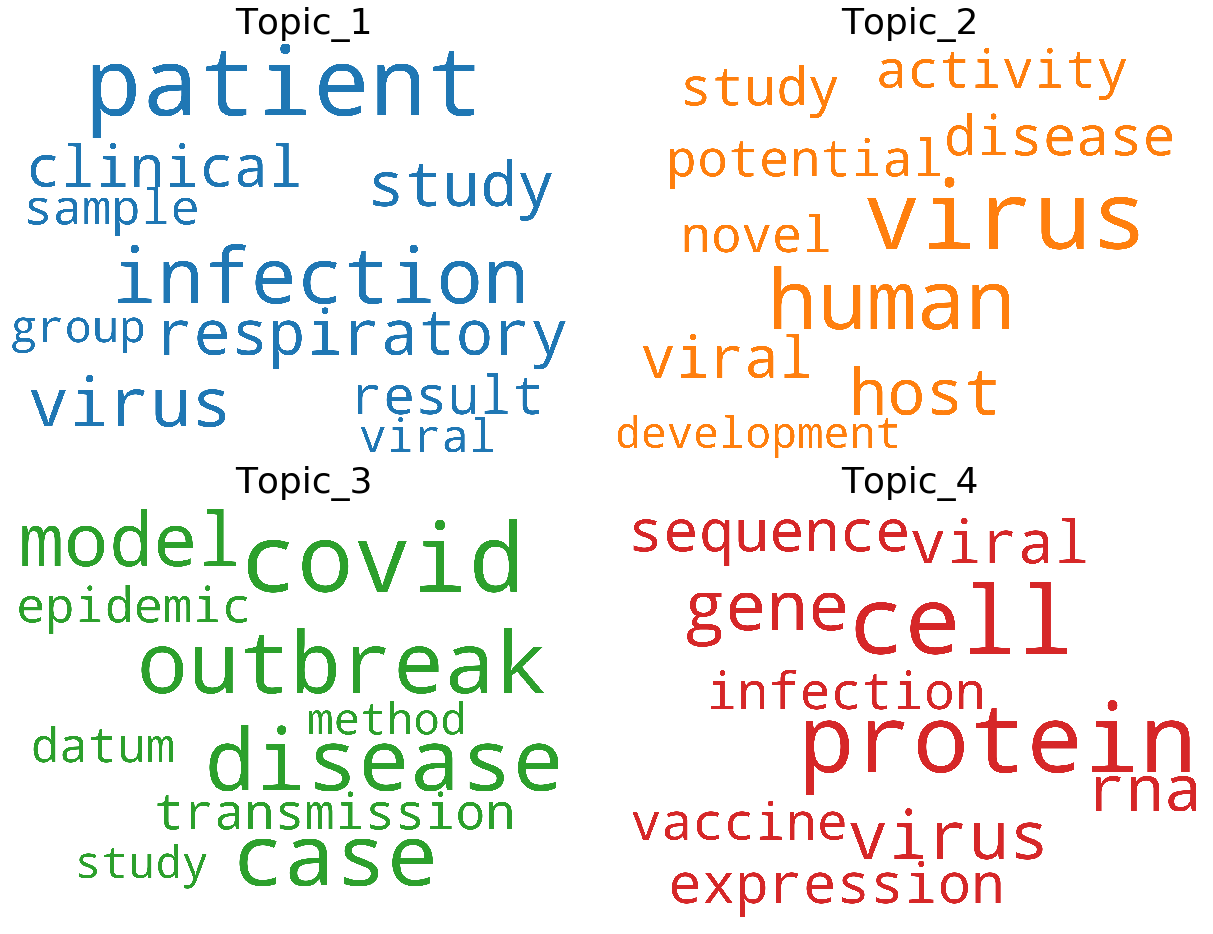

In [48]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=english_stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2,2, figsize=(17,13), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=400)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic_' + str(i+1), fontdict=dict(size=36))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [49]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
df.sort_values('importance', ascending=False, inplace=True)
print(df.shape)
df.head()

(40, 4)


,word,topic_id,importance,word_count
30,protein,3,0.035619,18506
31,cell,3,0.035298,23985
0,patient,0,0.033426,16574
10,virus,1,0.022172,40746
1,infection,0,0.021251,27832


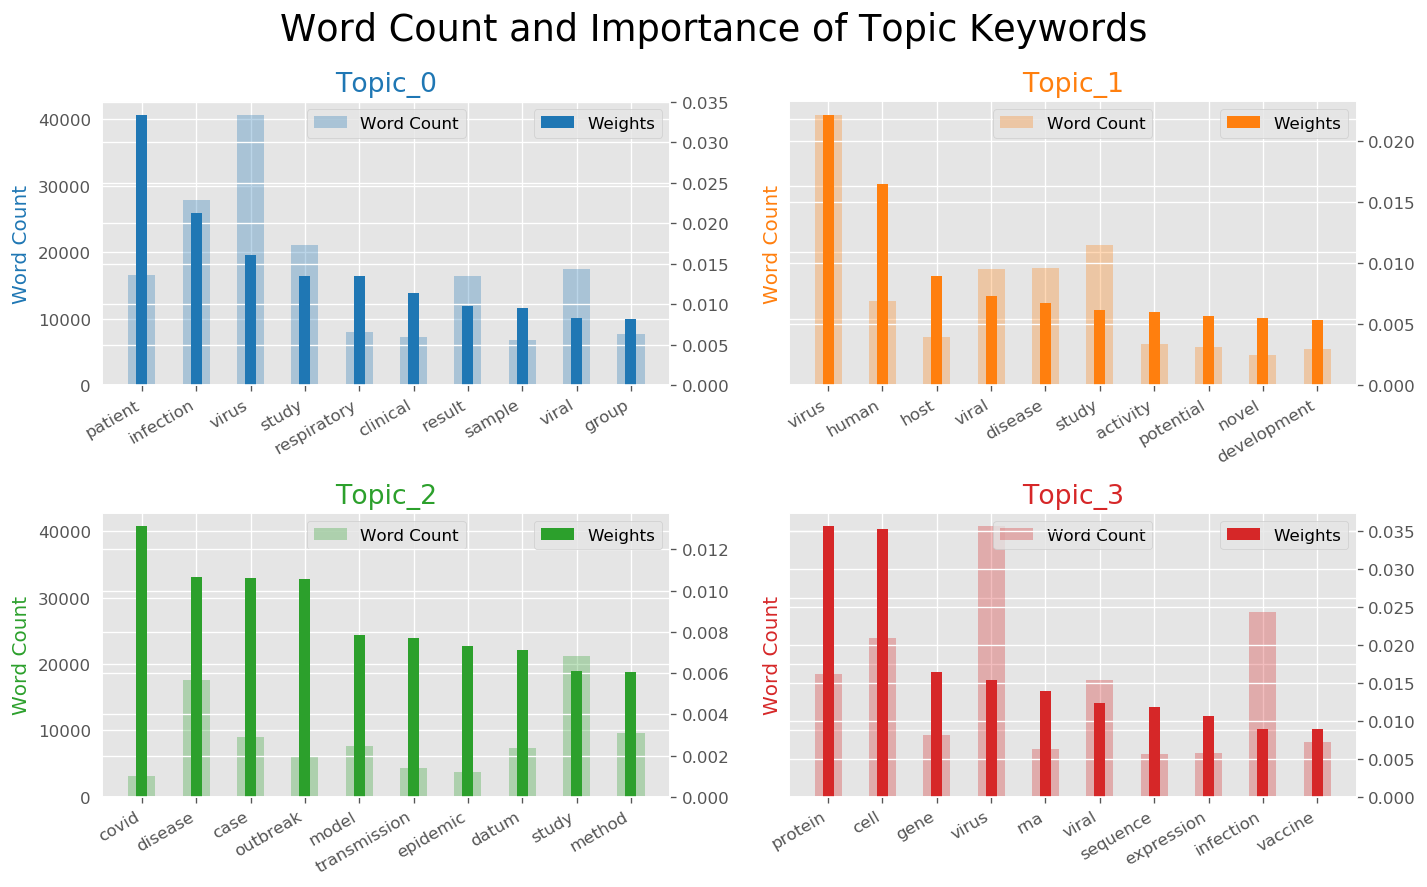

In [50]:
# Plot Word Count and Weights of Topic Keywords 
fig, axes = plt.subplots(2, 2, figsize=(12,7), sharey=True, dpi=120)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.040); ax.set_ylim(0, 40000)
    ax.set_title('Topic_' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper center'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [51]:
doc_lda = lda_model[corpus]
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=list(cord19_df.abstract.values)):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list 
        row = sorted(row, key=lambda x: (x[1]), reverse=True) 
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
                
    sent_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    return(sent_topics_df) 


In [52]:
%%time
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['doc_id', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'text']

df_dominant_topic.sort_values(by='topic_perc_contrib',  ascending=False, inplace=True)
df_dominant_topic.head(5)

CPU times: user 2min 17s, sys: 961 ms, total: 2min 18s
Wall time: 2min 18s


,doc_id,dominant_topic,topic_perc_contrib,keywords,text
9710,9710,2.0,0.9957,"covid, disease, case, outbreak, model, transmission, epidemic, datum, study, method","[objective, assess, private, hospital, development, china, global, perspective, method, search, ..."
16333,16333,0.0,0.9947,"patient, infection, virus, study, respiratory, clinical, result, sample, viral, group","[background, unclarified, viral, detection, genotype, relate, child, hmpv, infection, lrti, clin..."
23080,23080,2.0,0.9947,"covid, disease, case, outbreak, model, transmission, epidemic, datum, study, method","[unprecedented, measure, adopt, control, rapid, spread, ongoing, covid, epidemic, china, people,..."
25635,25635,2.0,0.9946,"covid, disease, case, outbreak, model, transmission, epidemic, datum, study, method","[early, phase, covid, pandemic, chiefly, report, city, wuhan, case, export, location, largely, p..."
9867,9867,2.0,0.9944,"covid, disease, case, outbreak, model, transmission, epidemic, datum, study, method","[background, objective, study, explore, perception, local, sar, extranet, potential, support, fu..."


In [53]:
print('The percentage of documents that dominated the topic has less than 80% contribution is: {}%'.format(
      round(len(df_dominant_topic.loc[df_dominant_topic.topic_perc_contrib<=0.50])/len(df_dominant_topic)*100,2)))

The percentage of documents that dominated the topic has less than 80% contribution is: 25.27%


In [54]:
# Display setting to show more characters in column 
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('dominant_topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['perc_contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index 
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format 
sent_topics_sorteddf_mallet.columns = ['no_topic', "topic_perc_contrib", "keywords", "representative text"]

# Show 
sent_topics_sorteddf_mallet

,no_topic,topic_perc_contrib,keywords,representative text
0,0.0,0.9947,"patient, infection, virus, study, respiratory, clinical, result, sample, viral, group","[background, unclarified, viral, detection, genotype, relate, child, hmpv, infection, lrti, clin..."
1,1.0,0.9856,"virus, human, host, viral, disease, study, activity, potential, novel, development","[rhubarb, rheum, emodi, family, polygonaceae, traditionally, diuretic, liver, stimulant, purgati..."
2,2.0,0.9957,"covid, disease, case, outbreak, model, transmission, epidemic, datum, study, method","[objective, assess, private, hospital, development, china, global, perspective, method, search, ..."
3,3.0,0.9475,"protein, cell, gene, virus, rna, viral, sequence, expression, infection, vaccine","[system, express, amino_terminal, half, murine, coronavirus, jhmv, peplomer, glycoprotein, insec..."


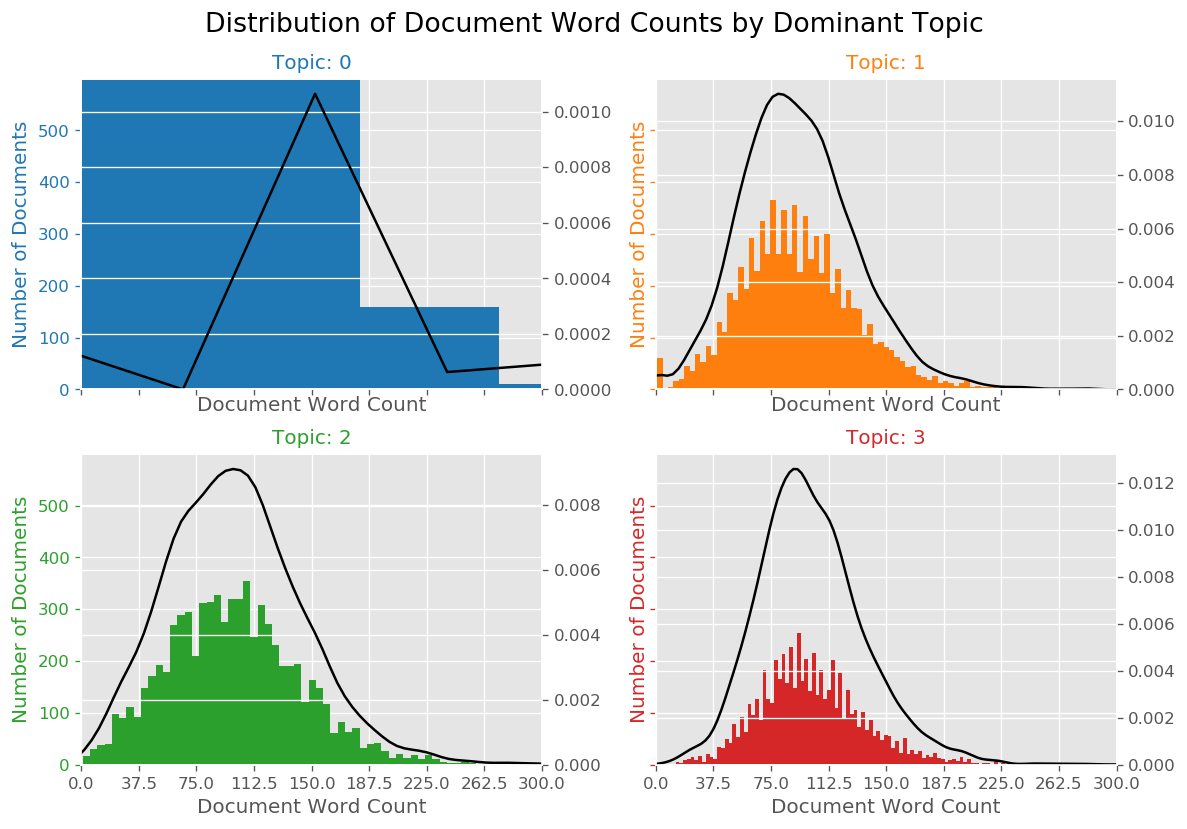

In [55]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2, figsize=(10,7), dpi=120, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.dominant_topic == i,:]
    doc_lens = [len(d) for d in df_dominant_topic_sub.text]
    ax.hist(doc_lens, bins = 120, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 300), ylim=(0, max(doc_lens)+300), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=12, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,300,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=16)
plt.show()

In [56]:
# Sentence Coloring of N Sentences

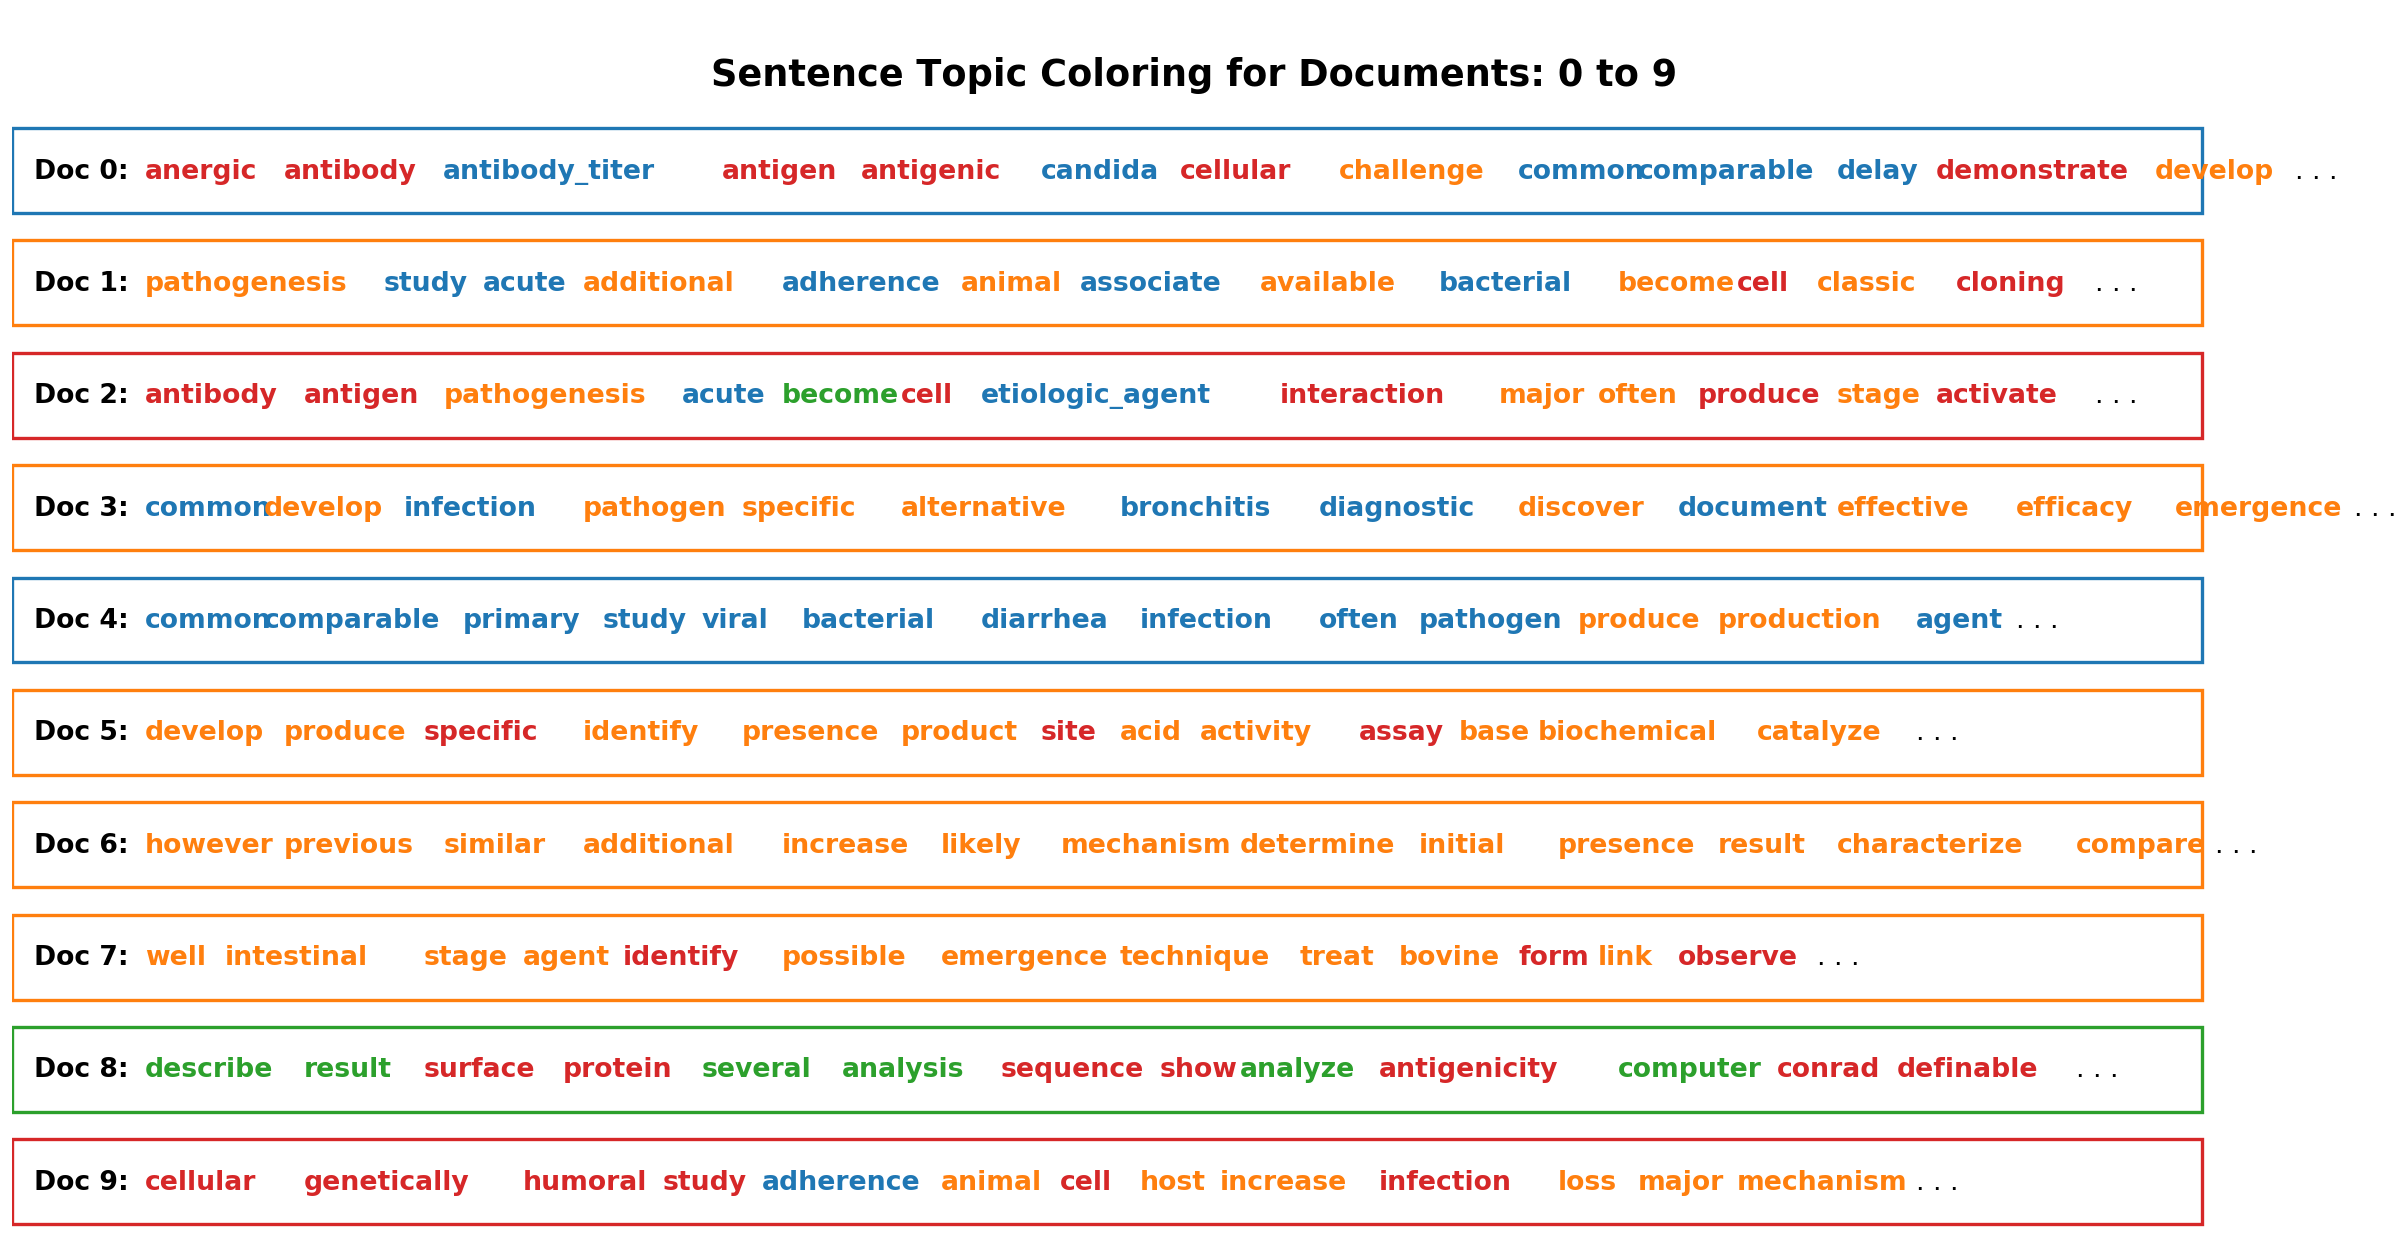

In [57]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=11):
    
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=120)       
    axes[0].axis('off')
    
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics] 
            
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)
            
            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))
            
            word_pos = 0.06 
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 13:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
                    
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: '+str(start)+' to '+str(end-2),
                 fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [58]:
%%time
import pyLDAvis.gensim
pyLDAvis.enable_notebook(local=False)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis 

CPU times: user 43.3 s, sys: 3.98 s, total: 47.3 s
Wall time: 49.2 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.077300  0.190261       1        1  28.396696
2      0.165549  0.040515       2        1  26.958006
0      0.078786 -0.238849       3        1  23.681091
3     -0.321635  0.008072       4        1  20.964201, topic_info=            Term          Freq         Total Category  logprob  loglift
292      protein  20821.000000  20821.000000  Default  30.0000  30.0000
60          cell  21963.000000  21963.000000  Default  29.0000  29.0000
246      patient  23472.000000  23472.000000  Default  28.0000  28.0000
78          gene   9616.000000   9616.000000  Default  27.0000  27.0000
13696      covid   9865.000000   9865.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
84     infection   5224.325684  26875.216797   Topic4  -4.7175  -0.0755
8194         sar   3561.004150   8796.093750   Topic4  -5.1008   0.6581
167       result   4261.661133  16224.059570   Topic4  -4.9212   0.2255
300      suggest   3088.783203   6692.031738   Topic4  -5.2431   0.7892
45         study   3600.880371  21943.472656   Topic4  -5.0897  -0.2449

[272 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
8873      1  0.999529         ace
433       4  0.999687  activation
257       1  0.856945    activity
257       4  0.143005    activity
52        3  0.999875       acute
...     ...       ...         ...
594       1  0.999067        vivo
50        1  0.546260        well
50        2  0.287954        well
50        3  0.119833        well
50        4  0.045980        well

[406 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

------------
# References
COVID-19 Open Research Dataset Challenge ([CORD-19](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge#PMC1616946.xml.json))
### QA:
- Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova (24 May 2019, Google AI Language); BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding; [PDF](https://arxiv.org/pdf/1810.04805.pdf); [YouTube](https://www.youtube.com/watch?v=iDulhoQ2pro)  
- Google Research (New March 11th, 2020: Smaller BERT Models), [GitHub](https://github.com/google-research/bert)  
- [Question Answering System In Python Using BERT NLP](https://www.pragnakalp.com/case-study/question-answering-system-in-python-using-bert-nlp/)  
- Jonathan Besomi, [A QA model to answer them all](https://www.kaggle.com/jonathanbesomi/a-qa-model-to-answer-them-all), on the [COVID-19 Open Research Dataset challenge](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks)  
- Thilina Rajapakse(Nov 17, 2019); Question Answering with BERT, XLNET, XLM, and DistilBERT using Simple Transformers; [Medium](https://towardsdatascience.com/question-answering-with-bert-xlnet-xlm-and-distilbert-using-simple-transformers-4d8785ee762a)  
- Ranjan Satapathy (Aug 11, 2018); Question Answering in Natural Language Processing; [Medium](https://medium.com/lingvo-masino/question-and-answering-in-natural-language-processing-part-i-168f00291856)  
- Akshay Navalakha (May 15, 2019); NLP — Question Answering System using Deep Learning; [Medium](https://medium.com/@akshaynavalakha/nlp-question-answering-system-f05825ef35c8)  
- The Stanford Question Answering Dataset ([SQuAD](https://rajpurkar.github.io/SQuAD-explorer/))  
- Tweet Sentiment Extraction: Extract support phrases for sentiment labels; [Kaggle](https://www.kaggle.com/c/tweet-sentiment-extraction/discussion)  
- Yuriy Ostapov (18 Nov 2011); Question Answering in a Natural Language: Understanding System Based on Object–Oriented Semantics; [PDF](https://arxiv.org/pdf/1111.4343.pdf) 
- Yi Yang, Wen-tau Yih and Christopher Meek((2015); WIKIQA: A Challenge Dataset for Open-Domain Question Answering; [PDF](https://www.aclweb.org/anthology/D15-1237.pdf)  
### LDA:
- Latent Dirichlet Allocation by Andrew Y. Ng, David M. Blei, Michael I. Jordan (Journal of Machine Learning Research 3; 2003); [PDF](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)  
- [Topic Modelling](https://malaya.readthedocs.io/en/latest/Topic.html#topic=0&lambda=1&term=)
- N-gramme; [Wikimedia](https://fr.wikipedia.org/wiki/N-gramme)

### Other resources
[YouTube](https://www.youtube.com/watch?v=54XLXg4fYsc) ==> https://aatishb.com/covidtrends/ 

------------------------------------
------------------------------------
------------------------------------